In [1]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Initial Parameters

In [2]:
Nx = 8; Ny = 10; N=Nx*Ny; p = 1; q = 10; cut_off = 8;
PN = [0,1,2,3];
U = 2;

# Single-Particle

In [3]:
@doc get_sp_op

Compute the single-particle operator from single-particle matrix.

#### Arguments

  * `sp_basis::NLevelBasis`: Single-Particle basis.
  * `N::Integer`: The total site number.
  * `sp_matrix::Matrix`: Hopping phases matrix from any model.


In [4]:
sp_basis = NLevelBasis(N)
periodicity = 0
sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity);

In [5]:
H1 = get_sp_op(sp_basis, N, sp_matrix);

In [6]:
using LinearAlgebra
eigenenergies(dense(H1)) == eigvals(sp_matrix) # true
show(stdout, "text/plain", eigvals(sp_matrix))

80-element Vector{Float64}:
 -3.420053641408173
 -3.4200536414081695
 -3.4200153004721425
 -3.420015300472141
 -3.4200153004721403
 -3.4200153004721376
 -3.419976950201189
 -3.419976950201185
 -2.35230282337433
 -2.35230282337433
 -2.351552346547092
 -2.351552346547092
 -2.351552346547092
 -2.351552346547091
 -2.3507988713924597
 -2.3507988713924592
 -1.4776985043449289
 -1.477698504344928
 -1.4715820869198095
 -1.4715820869198095
 -1.4715820869198086
 -1.4715820869198086
 -1.465283441759455
 -1.4652834417594534
 -0.7570660026277768
 -0.7570660026277768
 -0.7258326903745499
 -0.7258326903745488
 -0.7258326903745481
 -0.7258326903745479
 -0.6882911202826466
 -0.6882911202826453
 -0.3458904742074982
 -0.3458904742074975
 -0.28514903651549856
 -0.28514903651549783
 -0.2851490365154978
 -0.2851490365154963
 -0.2241084340414668
 -0.22410843404146663
  0.22410843404146696
  0.22410843404146735
  0.2851490365154943
  0.2851490365154979
  0.2851490365154984
  0.2851490365154986
  0.34589047420

In [7]:
@doc get_sub_states

Compute the first eigen-states in a given number.

#### Arguments

  * `sp_op::get_sp_op`: Single-particle operator.
  * `cut_off::Int`: Limit value of eigen-state index.


In [8]:
sub_states = get_sub_states(H1, cut_off);

In [9]:
@doc get_projector_op

Compute sub-space basis, projection and comlex conjugate of projection operator.

#### Arguments

  * `states::get_sub_states`: Eigen-states of the sub-space.
  * `basis::NLevelBasis`: Single-particle basis.


In [10]:
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [11]:
@doc get_subspace_op

Compute the corresponding operator in the sub-space.

#### Arguments

  * `sp_op::Operator`: Single-particle operator from single-particle matrix.
  * `P::get_projector_op[2]`: Projection operator.
  * `Pt::get_projector_op[3]`: Complex conjugate of projection operator.


In [12]:
H1_sub = get_subspace_op(H1, P, Pt);

In [13]:
@doc get_num_sub_list

Compute the single-particle number operator for each lattice sites.

#### Arguments

  * `N::Integer`: The total site number.
  * `sp_basis::NLevelBasis`: Single-Particle basis.
  * `P::get_projector_op[2]`: Projection operator.
  * `Pt::get_projector_op[3]`: Complex conjugate of projection operator.


In [14]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

# Many-Body

In [15]:
@doc get_mb_op

Compute the many-body operator for boson particles from single-particle operator.

#### Arguments

  * `basis_mb`: Many-body basis.
  * `basis_sub::get_projector_op[1]`: Sub-space basis.
  * `sp_op::Operator`: Single-particle operator from single-particle matrix.


In [16]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [17]:
H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub);

In [18]:
# states_mb = bosonstates(b_sub, PN) 
# basis_mb = ManyBodyBasis(b_sub, states_mb)

In [19]:
# H1_MB = get_mb_op(basis_mb, b_sub, H1_sub);

In [20]:
# @doc get_num_mb_list

In [21]:
# num_mb_list = get_num_mb_list(basis_mb, b_sub, num_sub_list);

In [22]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme")

Hofstadter_Finite_U (generic function with 1 method)

In [23]:
@doc Hubbard_Interaction

Compute the on-site Bose-Hubbard Interaction term.

#### Arguments:

  * `basis_cut_sp`: The cutt-off sites of bosonic many-body basis.
  * `basis_cut_mb`: The cutt-off sites of single-particle basis.
  * `P::Operator`: Projection operator.
  * `Pt::Operator`: Complex conjugate of projection operator.
  * `cut_off::Int`: Limit value of eigen-state index.


In [24]:
#bcut_mb, bcut = get_Bosonic_MB_Basis(cut_off,PN)
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN)
H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off);

# Constructing Total Hamiltonians 

In [25]:
H1cut = SparseOperator(basis_cut_mb)
H1cut.data = H1_MB.data

number_mb_list_operators = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)

V = 4
V_imp = V * number_mb_list_operators[45];
H_total = H1cut + H_Int + V_imp;

# Exact-Diagonalization

In [26]:
using DataFrames

E, U = eigenstates(dense(dense((H_total+dagger(H_total))/2)))

function get_energies(pn, E, U, basis)
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), U[i])) #expected values (first column)
        PN_Energies[i,2] = E[i] #eigen-values (second column)
    end
    
    # filter
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [27]:
pn = 3.0
df = get_energies(pn, E, U, basis_cut_mb)
filtered_energies = Matrix(df)[:,2]
show(stdout,"text/plain", filtered_energies) #show all outputs

120-element Vector{Float64}:
 -10.25989036827856
 -10.259884355536734
 -10.259864512378334
 -10.25985088435604
 -10.259839167727383
 -10.259824249734958
 -10.259823526897181
 -10.222086796366424
 -10.222016263190625
 -10.219513235302074
 -10.217732415278812
 -10.199841575511721
 -10.1964634812048
 -10.196370276921026
 -10.193897972434371
 -10.18860962520194
 -10.187124685014217
 -10.18711737709193
 -10.186720279397345
 -10.183076329588461
 -10.182809071771734
 -10.181271453209526
 -10.180632539389771
 -10.180167831109156
 -10.175528903872726
 -10.17527270547827
 -10.174944755401095
 -10.171993940011
 -10.167254547436373
 -10.164251522521697
 -10.163728078503043
 -10.163179883638062
 -10.162923289754174
 -10.162657819150247
 -10.162633162769872
 -10.157337248745863
 -10.152867101057538
 -10.152843232284178
 -10.15257961344863
 -10.150766859209641
 -10.14889866450043
 -10.147560425983405
 -10.147117480991529
 -10.142554852804855
 -10.142387363239061
 -10.1399374999124
 -10.13503551259928

Allta ki fonksiyonun çalışması için, dizide ki filtre edilmiş parçacık sayısı her zaman en büyük değer de olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [28]:
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[1:number_of_states];
end

Restricted_Hubbard_States (generic function with 1 method)

In [29]:
r_hubbard_states = Restricted_Hubbard_States(U);

# Density Profile

In [30]:
# METHOD 1

NM_MB_Array_Storage = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb));
for m in 1:N
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            #NM_MB_Matrix[i,j] = num_mb_list[m].data[i,j]
            NM_MB_Matrix[i,j] = number_mb_list_operators[m].data[i,j]
            # NOT: num_mb_list ile number_mb_list_operators bazları farklı ama içerikleri aynı!
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end

BL = BR = basis_cut_mb
index_number_op = 4
T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T)
index_eigen_states = 1
expect(Op, r_hubbard_states[index_eigen_states])

#or
# expect(number_mb_list_operators[index_number_op],r_hubbard_states[index_eigen_states])

0.059204140591287 - 1.1100366773767606e-18im

In [31]:
PN

4-element Vector{Int64}:
 0
 1
 2
 3

In [32]:
Sum = 0
total_expect_list=[]

for i in 1:N
    T = NM_MB_Array_Storage[:,:,i]
    Op = Operator(BL,BR,T)
    n_i = 0
    for index_eig_states in 1:q        
        Sum += expect(Op, r_hubbard_states[index_eig_states])
        #println(i,"\t",expect(Op, r_hubbard_states[index_eig_states]))
        n_i += expect(Op, r_hubbard_states[index_eig_states])
    end
    push!(total_expect_list,n_i)
end

In [33]:
index_eig_states = 1
Sum = 0
expect_list=[]

for i in 1:N
    T = NM_MB_Array_Storage[:,:,i]
    Op = Operator(BL,BR,T)      
    Sum += expect(Op, r_hubbard_states[index_eig_states])
    #println(i,"\t",expect(Op, r_hubbard_states[index_eig_states]))
    push!(expect_list,expect(Op, r_hubbard_states[index_eig_states]))
end
Sum

3.0000000000000004 - 6.812805910105764e-18im

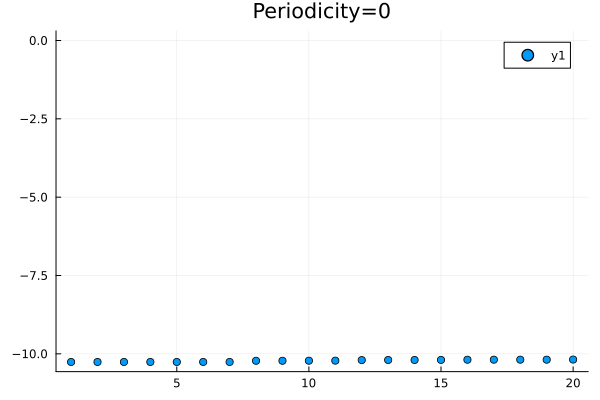

In [34]:
using Plots
plot(1:20,E,seriestype=:scatter,title="Periodicity=$(periodicity)")

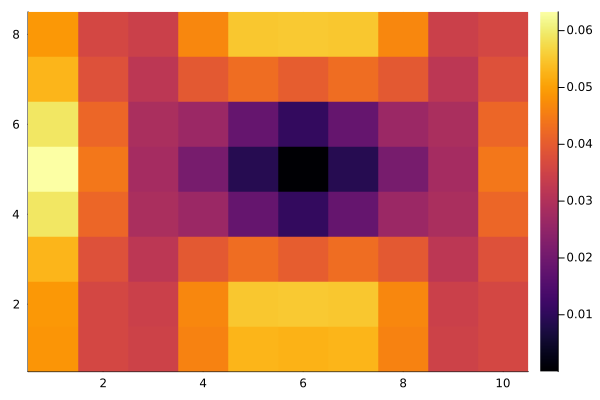

In [42]:
heatmap(reshape(real(total_expect_list), Nx, Ny))
heatmap(reshape(real(expect_list), Nx, Ny))

# Animation

In [38]:
# animated_exp_list = zeros(N,1,length(r_hubbard_states))
# function animated_e_l()
#     for i in 1:length(r_hubbard_states)
#         expect_list=[]
#         for j in 1:N
#             T = NM_MB_Array_Storage[:,:,j]
#             Op = Operator(BL,BR,T)
#             push!(expect_list,expect(Op, r_hubbard_states[i]))
#         end
#         animated_exp_list[:,:,i] = real(expect_list)
#     end
#     return animated_exp_list
# end

In [39]:
# k = 1
# initial_condition = reshape(animated_e_l()[:,:,k], Nx, Ny) #psi_1 (psi_k)'e karşılık gelen density matrix
# heatmap(initial_condition)

In [40]:
# initial_condition = reshape(animated_e_l()[:,:,1], Nx, Ny)
# fps = 20
# function heatgif(initial_condition)
#     p = heatmap(initial_condition, xlabel="x", ylabel="y", title=("Nx=$Nx,Ny=$Ny,co=$cut_off,PN=$pn,U=$U, fps=$fps"))
#     anim = @animate for i=1:length(r_hubbard_states)
#         h_map_matrix = reshape(animated_e_l()[:,:,i],Nx,Ny)
#         heatmap!(p[1], h_map_matrix)
#     end
#     return anim
# end

In [41]:
# anim = heatgif(initial_condition)
# gif(anim, "OUTPUT.gif", fps=fps)